In [1]:
import os
os.chdir('./..')

import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler
from sklearn.cluster import KMeans

from src.utils import REPO_PATH, MODELS_PATH, DATA_PATH

SEED = 42

In [2]:
DATA_FILE_PATH = os.path.join(DATA_PATH, 'rfm_data.csv')
rfm_metrics = pd.read_csv(DATA_FILE_PATH)
display(rfm_metrics)

,recency,frequency,monetary_value
0,325,1,77183.60
1,2,7,4310.00
2,75,4,1797.24
3,18,1,1757.55
4,310,1,334.40
...,...,...,...
4334,277,1,180.60
4335,180,1,80.82
4336,7,2,178.05
4337,3,16,2094.88


Since K-Means Clustering is built on Euclidean distances between points, we need to scale the RFM metrics so every feature is equally important. Before that, let's look at the spread of each individual feature.

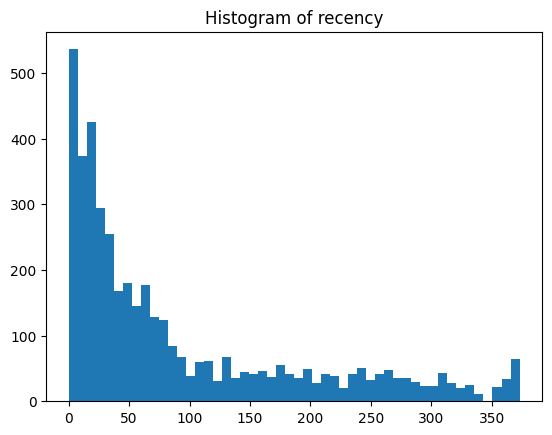

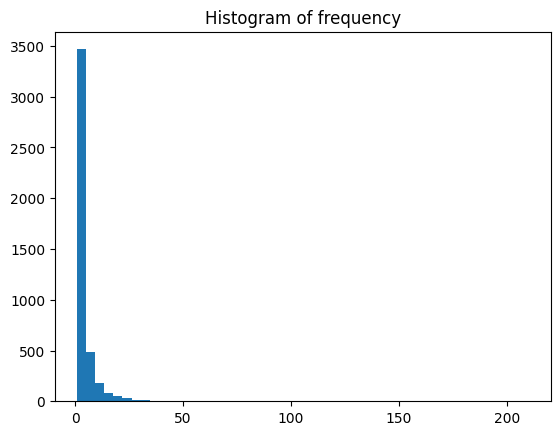

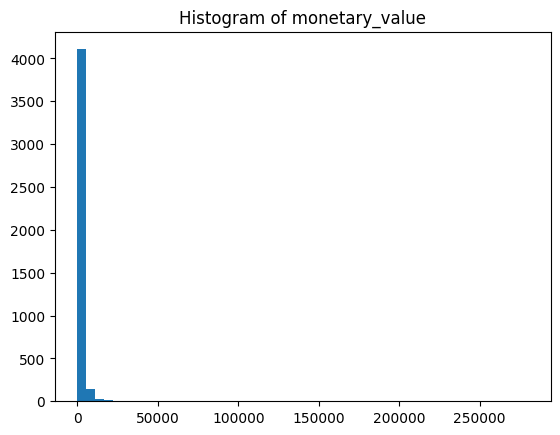

In [3]:
for feature in rfm_metrics.columns:
    plt.hist(rfm_metrics[feature], bins=50)
    plt.title(f'Histogram of {feature}')
    plt.show()

It seems like there are little to no outliers for the `recency` feature. This is not true for the `frequency` and `monetary_value` though. This means that using min-max scaling and standard scaling will not be very good as the outliers will squeeze the inliers together. Let's use scikit learn's robust scaler instead.

In [4]:
robust_scaler = RobustScaler()
robust_scaler.fit(rfm_metrics)
rfm_metrics_scaled = robust_scaler.transform(rfm_metrics)

rfm_metrics_scaled = pd.DataFrame(rfm_metrics_scaled, columns=rfm_metrics.columns)

rfm_metrics_scaled.to_csv(os.path.join(DATA_PATH, "rfm_metrics_scaled.csv"), index=False)
pickle.dump(robust_scaler, open(os.path.join(MODELS_PATH, 'scaler.pkl'), 'wb'))

display(rfm_metrics_scaled)

,recency,frequency,monetary_value
0,2.208835,-0.25,56.489540
1,-0.385542,1.25,2.684261
2,0.200803,0.50,0.828997
3,-0.257028,-0.25,0.799693
4,2.088353,-0.25,-0.251072
...,...,...,...
4334,1.823293,-0.25,-0.364628
4335,1.044177,-0.25,-0.438299
4336,-0.345382,0.00,-0.366511
4337,-0.377510,3.50,1.048756


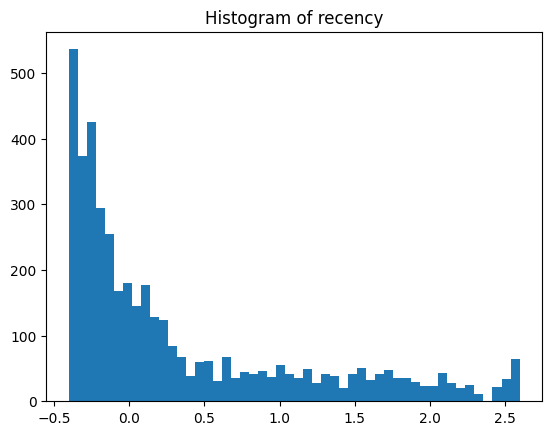

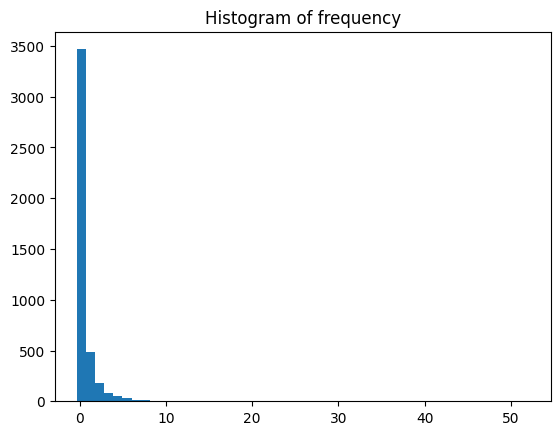

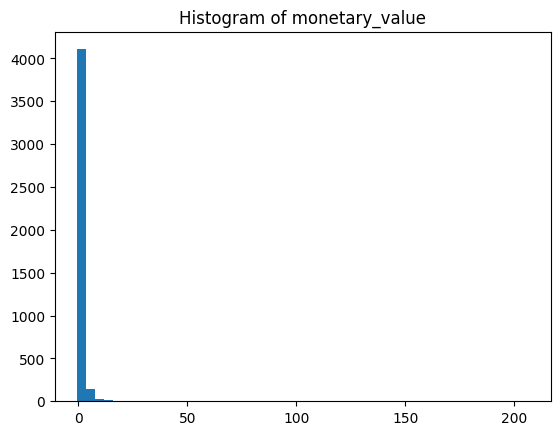

In [5]:
for feature in rfm_metrics_scaled.columns:
    plt.hist(rfm_metrics_scaled[feature], bins=50)
    plt.title(f'Histogram of {feature}')
    plt.show()

We're now ready for building the K-Means model. We'll try building models with k = 1..20 while keeping track of the mean WCSS across all clusters for each model. We'll then use the elbow method to select the "best" value for k.

In [6]:
wcss = []
max_clusters = 20
for i in range(1, max_clusters + 1): 
    kmeans = KMeans(n_clusters = i, random_state = SEED)
    kmeans.fit(rfm_metrics_scaled) 
    wcss.append(kmeans.inertia_)

c:\Users\ernes\AppData\Local\Miniconda3\envs\customer_segmentation\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\ernes\AppData\Local\Miniconda3\envs\customer_segmentation\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


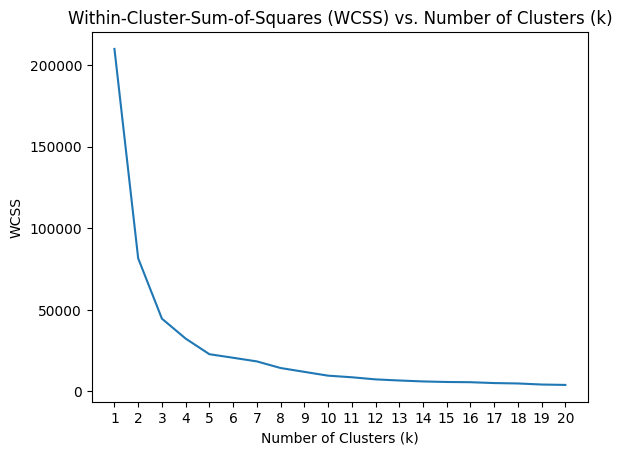

In [7]:
plt.plot(list(range(1, max_clusters + 1)), wcss)
plt.xticks(list(range(1, max_clusters + 1)))
plt.title("Within-Cluster-Sum-of-Squares (WCSS) vs. Number of Clusters (k)")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("WCSS")
plt.show()

By eyeballing the graph above, I chose a value of `k = 5`.

In [8]:
chosen_kmeans = KMeans(n_clusters = 5, random_state = SEED)
chosen_kmeans.fit(rfm_metrics_scaled)
model_name = "kmeans-k5"
with open(os.path.join(MODELS_PATH, f'{model_name}.pkl'), 'wb') as f:
    pickle.dump(chosen_kmeans, f)

Next, we use the model to conduct inference to see what characteristics customers from each cluster have that are similar within clusters, but different across clusters.